In [75]:
import numpy as np
import pandas as pd
import pymysql
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import requests
import itertools
#from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
conn = pymysql.connect(host='localhost', user='root', password='Sk1ttles', db='nba_stats_prod', autocommit=True)

In [161]:
train = """

select basic.player_id,
      -- reg_avg.season,
       box_view.team,
       box_view.game_hash,
       box_view.game_date,
       box_view.home_away,
       basic.pts,
       basic.minutes_played,
       basic.fg,
       basic.fga,
       basic.fg_pct,
       basic.3p,
       basic.3pa,
       basic.3p_pct,
       basic.ft,
       basic.ft_pct,
       basic.orb,
       basic.drb,
       basic.trb,
       basic.ast,
       basic.stl,
       basic.blk,
       basic.tov,
       basic.pf,
       adv.true_shooting_pct,
       adv.effective_fg_pct,
       adv.3P_attempt_rate,
       adv.FT_attempt_rate,
       adv.offensive_reb_rate,
       adv.defensive_reb_rate,
       adv.total_reb_pct,
       adv.assist_pct,
       adv.steal_pct,
       adv.block_pct,
       adv.turnover_pct,
       adv.usage_pct,
       a_stats.pace,
       adv.offensive_rating,
       adv.defensive_rating,
       reg_avg.fg_m as tot_fg_m,
       reg_avg.fg_a as tot_fg_a,
       reg_avg.fg_pct as tot_fg_pct,
       reg_avg.3p_m as tot_3p_m,
       reg_avg.3p_a as tot_3p_a,
       reg_avg.3p_pct as tot_3p_pct,
       reg_avg.ft_m as tot_ft_m,
       reg_avg.ft_a as tot_ft_a,
       reg_avg.ft_pct as tot_ft_pct,
       reg_avg.or as tot_or,
       reg_avg.dr as tot_dr,
       reg_avg.reb as tot_reb,
       reg_avg.ast as tot_ast,
       reg_avg.blk as tot_blk,
       reg_avg.stl as tot_stl,
       reg_avg.pf as tot_pf,
       reg_avg.`TO` as tot_to,
       reg_avg.pts as tot_point
from (

    select m.game_hash, m.team, m.game_date, m.home_away, lu.season
    from box_scores_map_view as m
    inner join game_date_lookup as lu on m.game_date = lu.day
    where m.game_date < current_date and
          lu.season > 2005
    order by game_date desc

         ) as box_view
inner join player_team_map as play_m on ( (box_view.team = play_m.team) and (
        box_view.season = play_m.season) )
inner join basic_box_stats as basic on ( (box_view.game_hash = basic.game_hash) and (
        play_m.player_id = basic.player_id) )
inner join advanced_box_stats as adv on ( (box_view.game_hash = adv.game_hash) and (
        play_m.player_id = adv.player_id) )
inner join team_advanced_boxscore_stats as a_stats on ( (box_view.game_hash = a_stats.game_hash) and (box_view.team = a_stats.team) )
left outer join RegularSeasonAverages as reg_avg on ( (basic.player_id = reg_avg.player_id) and (box_view.season-1 = reg_avg.season) )
-- left outer join RegularSeasonTotals as reg_tot on ( (basic.player_id = reg_tot.player_id) and (box_view.season-1 = reg_tot,season) )
-- where reg_avg.season is not null
order by box_view.game_date desc;


"""

In [162]:
df = pd.read_sql(sql=train, con=conn, index_col=None)

In [163]:
def time_convert(minutes_played):
    time_list = minutes_played.split(':')
    try:
        return ((int(time_list[0]) * 60) + int(time_list[1]))
    except ValueError:
        return 0

In [164]:
def concat_drop(df, dummy_var_col, drop_list):
    for field in dummy_var_col:
        df = pd.concat([df, gen_dummby_var(df, field)], axis=1)
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [165]:
def gen_dummby_var(df, column):
    return pd.get_dummies(df[column], drop_first=True)

In [166]:
df.loc[:, 'minutes_played'] = df.loc[:, 'minutes_played'].apply(time_convert)

In [202]:
clean_df = concat_drop(df[df['minutes_played'] >= 1200], ['home_away'], ['player_id', 'team', 'game_hash', 'game_date', 'home_away', 'fg', '3p', 'ft'])

In [203]:
clean_df.head()

,pts,minutes_played,fga,fg_pct,3pa,3p_pct,ft_pct,orb,drb,trb,...,tot_or,tot_dr,tot_reb,tot_ast,tot_blk,tot_stl,tot_pf,tot_to,tot_point,Home
0,19,2213,17,0.412,9,0.111,1.00,0,6,6,...,0.7,3.7,4.4,4.5,0.4,1.2,2.0,2.6,22.6,0
3,4,1345,8,0.250,4,0.000,0.00,0,1,1,...,1.0,4.6,5.6,1.9,0.5,0.8,3.0,1.7,11.5,0
4,24,2462,20,0.400,6,0.333,0.75,1,3,4,...,0.5,3.1,3.7,9.6,1.1,1.4,2.0,3.9,19.4,0
7,8,1976,5,0.600,0,0.000,0.50,2,9,11,...,3.2,9.4,12.5,1.3,1.6,0.6,3.1,2.6,16.6,0
8,13,2166,15,0.333,7,0.429,0.00,1,5,6,...,0.9,3.6,4.5,6.6,0.4,1.1,1.6,2.8,26.9,1


In [204]:
clean_df = clean_df.fillna(0)

In [205]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.loc[:, 'minutes_played':], clean_df.loc[:, 'pts'], test_size=.33)

In [206]:
lm = LinearRegression()

In [207]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [208]:
predictions = lm.predict(X_test)

Text(0,0.5,'Predicted Y')

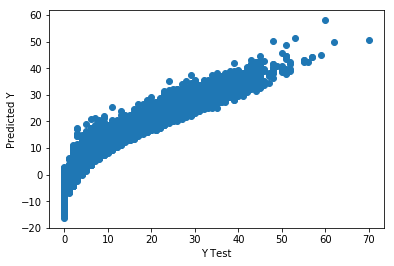

In [209]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

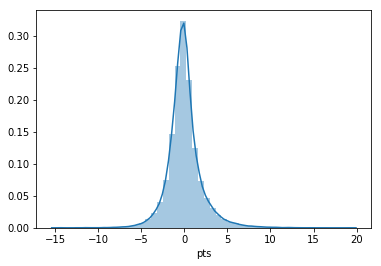

In [210]:
sns.distplot((y_test-predictions),bins=50);

In [211]:
coeffecients = pd.DataFrame(lm.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.003820
fga,0.683700
fg_pct,6.794868
3pa,0.052015
3p_pct,1.329538
ft_pct,-0.052801
orb,-0.086509
drb,0.062663
trb,-0.023846
ast,-0.386460


In [212]:
lm.score(X_test, y_test)

0.93165037744548207

In [213]:
### Experimenting with Lasso regression

In [228]:
lasso = Lasso(alpha=.75)

In [229]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.75, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [230]:
predictions = lasso.predict(X_test)

Text(0,0.5,'Predicted Y')

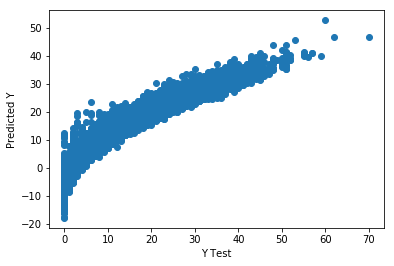

In [231]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

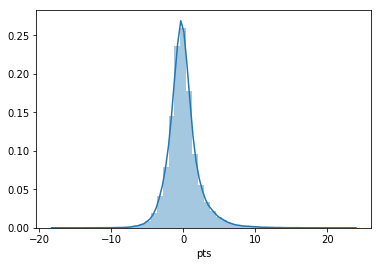

In [232]:
sns.distplot(y_test-predictions, bins=50)

In [233]:
lasso.score(X_test, y_test)

0.91745761228197842

In [225]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.005017
fga,0.396315
fg_pct,0.000000
3pa,0.000000
3p_pct,0.000000
ft_pct,-0.000000
orb,-0.000000
drb,0.000000
trb,0.000000
ast,-0.000000
